In [2]:
"""Clear Air Turbulence indices
This notebook calculates a range of indices for diagnosing clear air turbulence from gridded climate model data.
At the bottom of the notebook there are some quick plots for sanity checks. There is also some MOG calculations, but these belong in MOG.ipynb and CAT_evaluation.ipynb
"""

'Clear Air Turbulence indices\nThis notebook calculates a range of indices for diagnosing clear air turbulence from gridded climate model data.\nAt the bottom of the notebook there are some quick plots for sanity checks. There is also some MOG calculations, but these belong in MOG.ipynb and CAT_evaluation.ipynb\n'

In [2]:
# Code up some of the established indices 
# (guided by Lee et al. 2022, JGRA https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022JD037679) 
# and Kim et al. 2023 (https://www.nature.com/articles/s41612-023-00421-3) - also noting Storer et al. 
# (2017 GRL), Prosser et al. (2023 GRL) ) and apply to BARPA-A-historical dataset to determine
# current/recent statistics of CAT and the spatial patterns over BARPA-A domain.

In [3]:
# for plotting see https://github.com/AusClimateService/plotting_maps/blob/main/example_notebooks/FAQ_example_multi_plot_cbar_variations.ipynb

In [4]:
# consider saving the calculated indices on scratch or somewhere else

In [1]:
import xarray as xr
import glob
import intake
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
from matplotlib import colors, cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar
ProgressBar().register()

import dask
from dask.distributed import Client
client = Client(threads_per_worker=2, n_workers=28)
client


<Client: 'tcp://127.0.0.1:43475' processes=28 threads=56, memory=9.00 GiB>

2025-09-19 12:42:52,895 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40529'.
2025-09-19 12:42:52,926 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43815'.
2025-09-19 12:42:52,927 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39627'.
2025-09-19 12:42:52,930 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36899'.
2025-09-19 12:42:52,947 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:46427'.
2025-09-19 12:42:52,962 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43087'.


In [3]:
# these functions are used to calculate turbulence in climate models
# calculate differential components
def dy(ds, lon="lon", step_size=  0.1545,):
    """Step size in degrees. This function converts to metres"""
    return (step_size *111000 * ds[lon]**0).round()

def dx(ds, lat="lat", step_size=  0.1545,):
    """Step size in degrees. This function converts to metres"""
    return (step_size *111000 * np.cos( np.deg2rad(ds[lat]))).round()

def dz(ds, z="z", p0=200, p1=300):
    """Change in height"""
    return ds[z].sel(pressure=p0) - ds[z].sel(pressure=p1)
    
def du_dx(ds, u="u", lon="lon",lat="lat", p=250, step_size=  0.1545):
    """Change in horizontal wind u with change in longitude."""
    return ds[u].sel(pressure=p).differentiate(lon)/dx(ds, lat=lat, step_size= step_size,)

def dv_dx(ds, v="v", lon="lon",lat="lat", p=250, step_size=  0.1545):
    """Change in horizontal wind v with change in longitude.
    This function wraps similar du_dx function"""
    return du_dx(ds, u="v", lon=lon, lat=lat, p=p, step_size=step_size)

def du_dy(ds, u="u", lon="lon",lat="lat", p=250, step_size=  0.1545):
    """Change in horizontal wind u with change in latitude."""
    return ds[u].sel(pressure=p).differentiate(lat)/dy(ds, lon=lon, step_size= step_size,)

def dv_dy(ds, v="v", lon="lon",lat="lat", p=250, step_size=  0.1545):
    """Change in horizontal wind v with change in latitude.
    This function wraps similar du_dy function"""
    return du_dy(ds, u="v", lon=lon, lat=lat, p=p, step_size=step_size)

def du_dz(ds, u="u", z="z", p0=200, p1=300):
    """Change in horizontal wind u with change in  height."""
    return (ds[u].sel(pressure=p0) - ds[u].sel(pressure=p1))/dz(ds, z=z, p0=p0, p1=p1)

def dv_dz(ds, v="v", z="z", p0=200, p1=300):
    """Change in horizontal wind v with change in  height.
    This function wraps similar du_dz function"""
    return du_dz(ds, u="v", z=z, p0=p0, p1=p1)

# Calculate indices
def windspeed(ds, u="u", v="v",):
    """Horizontal windspeed"""
    return (ds[u]**2 + ds[v]**2)**0.5
    
def air_density(ds, t="t", P=250,):
    """Calculates air density from temperature (T) and pressure (P) according to the ideal gas law.
    R_specific is the specific gas constant for dry air
    Units: 
    * P in hPa (convert to Pa)
    * T in K
    * R_specific in J/kg/K
    """
    R_specific = 287.05
    T = ds[t]
    return P*100/(R_specific * T)
rho = air_density
    
def potential_temperature(ds, t = "t", P=250, P0=1000):
    """Calculates potential temperature from temperature (T) and pressure (P) according to the ideal gas law.
    R/c_p = 0.286 for air
    Units: 
    * P in hPa
    * T in K
    """
    T = ds[t]
    return T*(P/P0)**(0.286)
    
def vertical_temperature_gradient(ds, t="t", P0=1000, z="z", p0=200, p1=300):
    return (potential_temperature(ds, t=t, P=p0, P0=P0) - potential_temperature(ds, t=t, P=p1, P0=P0))/dz(ds, z=z, p0=p0, p1=p1)
dtheta_dz = vertical_temperature_gradient

def BruntVaisala_frequency(ds, t="t", P=250, P0=1000, z="z", p0=200, p1=300, g=9.81):
    """N^2 Brunt-Vӓisӓlӓ frequency"""
    return g/(potential_temperature(ds, t=t, P=P, P0=P0)) * dtheta_dz(ds, t=t, z=z, p0=p0, p1=p1)
N2 = BruntVaisala_frequency

def coriolis_freq(ds, lat="lat"):
    omega = 7.2921*10**-5
    return 2*omega*np.sin(np.deg2rad(ds[lat]))
f = coriolis_freq

def potential_vorticity(ds, t="t", P=250):
    "PV Potential Vorticity"
    zeta = dv_dx(ds) - du_dy(ds)
    f = coriolis_freq(ds)
    return 1/air_density(ds, t=t, P=P) * (zeta + f)* dtheta_dz(ds)
PV = potential_vorticity

def vertical_wind_shear(ds):
    return (((du_dz(ds))**2 + (dv_dz(ds))**2)**0.5)#.expand_dims({"pressure":[250]})
VWS = vertical_wind_shear

def deformation(ds):
    return ((du_dx(ds) -dv_dy(ds))**2 + (dv_dx(ds) + du_dy(ds))**2)**0.5
DEF = deformation

def divergence(ds):
    return du_dx(ds) + dv_dy(ds)
DIV = divergence

def divergence_tendency(ds):
    C=0.01
    return C*((divergence(ds).differentiate("time", datetime_unit="6h")**2)**0.5)
DVT = divergence_tendency

def richardson_number(ds):
    """The Ri less than some small number indicates Kelvin-Helmholtz instability when VWS is large and/or N2 is small."""
    return  N2(ds)/(vertical_wind_shear(ds)**2)
Ri = richardson_number

def turbulence_index_1(ds):
    return VWS(ds) * DEF(ds)
TI1 = turbulence_index_1

def turbulence_index_2(ds):
    return VWS(ds) * (DEF(ds) - DIV(ds))
TI2 = turbulence_index_2
    
def turbulence_index_3(ds):
    return TI1(ds) + DVT(ds)
TI3 = turbulence_index_3


# calculate all turbulence indices   
def calc_turbulence_indices(ds):
    # ds["air_density"] = air_density(ds)
    # ds["theta"] = theta(ds)
    # ds["dtheta_dz"] = dtheta_dz(ds)
    # ds["coriolis_freq"] = coriolis_freq(ds)
    ds["windspeed"]= windspeed(ds)
    ds["VWS"] = VWS(ds)
    ds["N2"] = N2(ds)
    ds["PV"] = PV(ds)
    ds["DEF"] = DEF(ds)
    ds["DIV"] = DIV(ds)
    ds["DVT"] = DVT(ds)
    ds["Ri"] = Ri(ds)
    ds["TI1"] = TI1(ds)
    ds["TI2"] = TI2(ds)
    ds["TI3"] = TI3(ds)
    return ds


In [4]:
# for BARRA

In [8]:
ds = xr.open_dataset("/g/data/cj37/BARRA/BARRA_R/v1/analysis/prs/wnd_ucmp/1990/01/wnd_ucmp-an-prs-PT0H-BARRA_R-v1-19900101T0000Z.sub.nc",
                     drop_variables= ["latitude_longitude", "forecast_period", "forecast_reference_time"],)\
                    .rename({"wnd_ucmp":"ua250", "latitude":"lat", "longitude":"lon"})\
                    .sel({"pressure":250}, method = "nearest")\
                    .sel(lat= slice(-50, -25), lon=slice(90.0485, 205.8915))
ds


<xarray.Dataset> Size: 887kB
Dimensions:   (lat: 227, lon: 972)
Coordinates:
    pressure  float64 8B 250.0
  * lat       (lat) float32 908B -49.93 -49.82 -49.71 ... -25.29 -25.18 -25.07
  * lon       (lon) float32 4kB 90.08 90.19 90.3 90.41 ... 196.7 196.8 196.9
    time      datetime64[ns] 8B ...
Data variables:
    ua250     (lat, lon) float32 883kB ...
Attributes: (12/56)
    source:                         Data from Met Office Unified Model
    um_version:                     10.2
    Conventions:                    CF-1.6, ACDD-1.3
    institution:                    Australian Bureau of Meteorology, GPO Box...
    title:                          Bureau of Meteorology Atmospheric high-re...
    summary:                        The Bureau of Meteorology Atmospheric hig...
    ...                             ...
    publisher_institution:          Australian Bureau of Meteorology
    publisher_name:                 Australian Bureau of Meteorology
    publisher_type:                 institution
    publisher_url:                  http://www.bom.gov.au
    naming_authority:               au.gov.bom
    history:                        2019-08-28T10:19:16,nwe548,/g/data1/dp9/r...

In [49]:
VAR = "wnd_ucmp"
filelist = glob.glob(f"/g/data/cj37/BARRA/BARRA_R/v1/analysis/prs/{VAR}/19[8-9][0-9]/*/{VAR}-an-prs-PT0H-BARRA_R-v1-*T*00Z.sub.nc")
filelist.sort()


In [53]:
%%time
def _preprocess(ds):
    return ds.drop_vars( [ "forecast_period", "forecast_reference_time", "latitude_longitude"],)\
    .sel({"pressure":250}, method = "nearest")\
    .sel(latitude= slice(-53.58 , 13.63), longitude=slice(88.04 , 207.9))\
    .chunk({"latitude":204, "longitude":330})

ds = xr.open_mfdataset(filelist, preprocess=_preprocess, combine="nested", concat_dim="time",)\
        .rename({"wnd_ucmp":"ua250", "latitude":"lat", "longitude":"lon"})\
        .chunk({"time":-1,})
ds

CPU times: user 38.2 s, sys: 16.3 s, total: 54.5 s
Wall time: 1min 19s


<xarray.Dataset> Size: 4GB
Dimensions:   (time: 1460, lat: 611, lon: 990)
Coordinates:
    pressure  float64 8B 250.0
  * lat       (lat) float32 2kB -53.56 -53.45 -53.34 ... 13.32 13.43 13.54
  * lon       (lon) float32 4kB 88.1 88.21 88.32 88.43 ... 196.7 196.8 196.9
  * time      (time) datetime64[ns] 12kB 1999-01-01 ... 1999-12-31T18:00:00
Data variables:
    ua250     (time, lat, lon) float32 4GB dask.array<chunksize=(1460, 204, 330), meta=np.ndarray>
Attributes: (12/56)
    source:                         Data from Met Office Unified Model
    um_version:                     10.2
    Conventions:                    CF-1.6, ACDD-1.3
    institution:                    Australian Bureau of Meteorology, GPO Box...
    title:                          Bureau of Meteorology Atmospheric high-re...
    summary:                        The Bureau of Meteorology Atmospheric hig...
    ...                             ...
    publisher_institution:          Australian Bureau of Meteorology
    publisher_name:                 Australian Bureau of Meteorology
    publisher_type:                 institution
    publisher_url:                  http://www.bom.gov.au
    naming_authority:               au.gov.bom
    history:                        2019-10-14T05:47:36,nwe548,/g/data1/dp9/r...

In [54]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:   (time: 1460, lat: 611, lon: 990)
Coordinates:
    pressure  float64 8B 250.0
  * lat       (lat) float32 2kB -53.56 -53.45 -53.34 ... 13.32 13.43 13.54
  * lon       (lon) float32 4kB 88.1 88.21 88.32 88.43 ... 196.7 196.8 196.9
  * time      (time) datetime64[ns] 12kB 1999-01-01 ... 1999-12-31T18:00:00
Data variables:
    ua250     (time, lat, lon) float32 4GB dask.array<chunksize=(1460, 204, 330), meta=np.ndarray>
Attributes: (12/56)
    source:                         Data from Met Office Unified Model
    um_version:                     10.2
    Conventions:                    CF-1.6, ACDD-1.3
    institution:                    Australian Bureau of Meteorology, GPO Box...
    title:                          Bureau of Meteorology Atmospheric high-re...
    summary:                        The Bureau of Meteorology Atmospheric hig...
    ...                             ...
    publisher_institution:          Australian Bureau of Meteorology
    publisher_name:                 Australian Bureau of Meteorology
    publisher_type:                 institution
    publisher_url:                  http://www.bom.gov.au
    naming_authority:               au.gov.bom
    history:                        2019-10-14T05:47:36,nwe548,/g/data1/dp9/r...

In [ ]:
# for BARPA etc

In [26]:
cat_name = "barpa"
col = intake.open_esm_datastore(f"/g/data/lp01/collections/py3.9_dev/nci-{cat_name}.json")

In [27]:
col.unique()

activity_id                                                    [BARPA-R]
institution_id                                                     [BOM]
version                [v20231001, v20240501, v20240401, v20240601, v...
variable_id            [CAPE, CIN, clh, clivi, cll, clm, clt, clwvi, ...
table_id                                        [1hr, 6hr, day, fx, mon]
source_id              [ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, ...
experiment_id           [historical, ssp126, ssp370, ssp585, evaluation]
member_id                      [r4i1p1f1, r6i1p1f1, r11i1p1f1, r1i1p1f1]
grid_label                                                      [AUS-15]
time_range             [196001-196012, 196101-196112, 196201-196212, ...
path                   [/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM...
derived_variable_id                                                   []
dtype: object

In [28]:
col.df["variable_id"].unique()

array(['CAPE', 'CIN', 'clh', 'clivi', 'cll', 'clm', 'clt', 'clwvi',
       'evspsbl', 'evspsblpot', 'hfls', 'hfss', 'hurs', 'huss', 'mrfsos',
       'mrsos', 'pr', 'prc', 'prsn', 'prw', 'ps', 'psl', 'rlds', 'rldscs',
       'rlus', 'rluscs', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdsdir',
       'rsdt', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'sfcWind', 'ta100m',
       'ta1500m', 'ta150m', 'ta200m', 'ta250m', 'ta50m', 'tas', 'tasmax',
       'tasmean', 'tasmin', 'ts', 'ua100m', 'ua1500m', 'ua150m', 'ua200m',
       'ua250m', 'ua50m', 'uas', 'uasmax', 'uasmean', 'va100m', 'va1500m',
       'va150m', 'va200m', 'va250m', 'va50m', 'vas', 'vasmax', 'vasmean',
       'wsgsmax', 'zmla', 'hus10', 'hus100', 'hus1000', 'hus150', 'hus20',
       'hus200', 'hus250', 'hus30', 'hus300', 'hus400', 'hus50', 'hus500',
       'hus600', 'hus70', 'hus700', 'hus850', 'hus925', 'hus950', 'mrfso',
       'mrfsol', 'mrro', 'mrros', 'mrso', 'mrsol', 'omega500', 'sic',
       'snd', 'snm', 'snw', 'ta10', 'ta100', '

In [11]:
# Edit this cell

var_list = ["ua200", "ua250", "ua300", "va200", "va250", "va300", "ta200", "ta250", "ta300", "zg200", "zg250", "zg300"]
table_id = "6hr"
scenarios = ["historical","ssp126", "ssp370", "ssp585", "evaluation"]

# change this query to select a subset of the data you are interested in
query = dict(variable_id = var_list[0],
             table_id = table_id,
             experiment_id = scenarios,
            )

cat = col.search(**query)
cat.unique()

activity_id                                                    [BARPA-R]
institution_id                                                     [BOM]
version                                                      [v20231001]
variable_id                                                      [ua200]
table_id                                                           [6hr]
source_id              [ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, ...
experiment_id           [historical, ssp126, ssp370, ssp585, evaluation]
member_id                      [r4i1p1f1, r6i1p1f1, r11i1p1f1, r1i1p1f1]
grid_label                                                      [AUS-15]
time_range             [196001-196012, 196101-196112, 196201-196212, ...
path                   [/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM...
derived_variable_id                                                   []
dtype: object

In [12]:
cat.df.groupby(["variable_id", "experiment_id", "source_id", "member_id"]).min()

activity_id institution_id  \
variable_id experiment_id source_id     member_id                              
ua200       evaluation    ERA5          r1i1p1f1      BARPA-R            BOM   
            historical    ACCESS-CM2    r4i1p1f1      BARPA-R            BOM   
                          ACCESS-ESM1-5 r6i1p1f1      BARPA-R            BOM   
                          CESM2         r11i1p1f1     BARPA-R            BOM   
                          CMCC-ESM2     r1i1p1f1      BARPA-R            BOM   
                          EC-Earth3     r1i1p1f1      BARPA-R            BOM   
                          MPI-ESM1-2-HR r1i1p1f1      BARPA-R            BOM   
                          NorESM2-MM    r1i1p1f1      BARPA-R            BOM   
            ssp126        ACCESS-CM2    r4i1p1f1      BARPA-R            BOM   
                          ACCESS-ESM1-5 r6i1p1f1      BARPA-R            BOM   
                          CESM2         r11i1p1f1     BARPA-R            BOM   
                          CMCC-ESM2     r1i1p1f1      BARPA-R            BOM   
                          EC-Earth3     r1i1p1f1      BARPA-R            BOM   
                          MPI-ESM1-2-HR r1i1p1f1      BARPA-R            BOM   
                          NorESM2-MM    r1i1p1f1      BARPA-R            BOM   
            ssp370        ACCESS-CM2    r4i1p1f1      BARPA-R            BOM   
                          ACCESS-ESM1-5 r6i1p1f1      BARPA-R            BOM   
                          CESM2         r11i1p1f1     BARPA-R            BOM   
                          CMCC-ESM2     r1i1p1f1      BARPA-R            BOM   
                          EC-Earth3     r1i1p1f1      BARPA-R            BOM   
                          MPI-ESM1-2-HR r1i1p1f1      BARPA-R            BOM   
                          NorESM2-MM    r1i1p1f1      BARPA-R            BOM   
            ssp585        ACCESS-CM2    r4i1p1f1      BARPA-R            BOM   
                          EC-Earth3     r1i1p1f1      BARPA-R            BOM   

                                                     version table_id  \
variable_id experiment_id source_id     member_id                       
ua200       evaluation    ERA5          r1i1p1f1   v20231001      6hr   
            historical    ACCESS-CM2    r4i1p1f1   v20231001      6hr   
                          ACCESS-ESM1-5 r6i1p1f1   v20231001      6hr   
                          CESM2         r11i1p1f1  v20231001      6hr   
                          CMCC-ESM2     r1i1p1f1   v20231001      6hr   
                          EC-Earth3     r1i1p1f1   v20231001      6hr   
                          MPI-ESM1-2-HR r1i1p1f1   v20231001      6hr   
                          NorESM2-MM    r1i1p1f1   v20231001      6hr   
            ssp126        ACCESS-CM2    r4i1p1f1   v20231001      6hr   
                          ACCESS-ESM1-5 r6i1p1f1   v20231001      6hr   
                          CESM2         r11i1p1f1  v20231001      6hr   
                          CMCC-ESM2     r1i1p1f1   v20231001      6hr   
                          EC-Earth3     r1i1p1f1   v20231001      6hr   
                          MPI-ESM1-2-HR r1i1p1f1   v20231001      6hr   
                          NorESM2-MM    r1i1p1f1   v20231001      6hr   
            ssp370        ACCESS-CM2    r4i1p1f1   v20231001      6hr   
                          ACCESS-ESM1-5 r6i1p1f1   v20231001      6hr   
                          CESM2         r11i1p1f1  v20231001      6hr   
                          CMCC-ESM2     r1i1p1f1   v20231001      6hr   
                          EC-Earth3     r1i1p1f1   v20231001      6hr   
                          MPI-ESM1-2-HR r1i1p1f1   v20231001      6hr   
                          NorESM2-MM    r1i1p1f1   v20231001      6hr   
            ssp585        ACCESS-CM2    r4i1p1f1   v20231001      6hr   
                          EC-Earth3     r1i1p1f1   v20231001      6hr   

                                                  grid_label     time_

In [13]:
# cat.df.groupby(["variable_id", "experiment_id", "source_id", "member_id"]).max()

In [14]:
cat_df_max = cat.df.groupby(["variable_id", "experiment_id", "source_id", "member_id"]).max().reset_index()
cat_df_max["index"] = cat_df_max.variable_id + "_" + cat_df_max.experiment_id + "_" + cat_df_max.source_id + "_" + cat_df_max.member_id
cat_df_max = cat_df_max.set_index("index")
cat_df_max

variable_id experiment_id  \
index                                                               
ua200_evaluation_ERA5_r1i1p1f1                ua200    evaluation   
ua200_historical_ACCESS-CM2_r4i1p1f1          ua200    historical   
ua200_historical_ACCESS-ESM1-5_r6i1p1f1       ua200    historical   
ua200_historical_CESM2_r11i1p1f1              ua200    historical   
ua200_historical_CMCC-ESM2_r1i1p1f1           ua200    historical   
ua200_historical_EC-Earth3_r1i1p1f1           ua200    historical   
ua200_historical_MPI-ESM1-2-HR_r1i1p1f1       ua200    historical   
ua200_historical_NorESM2-MM_r1i1p1f1          ua200    historical   
ua200_ssp126_ACCESS-CM2_r4i1p1f1              ua200        ssp126   
ua200_ssp126_ACCESS-ESM1-5_r6i1p1f1           ua200        ssp126   
ua200_ssp126_CESM2_r11i1p1f1                  ua200        ssp126   
ua200_ssp126_CMCC-ESM2_r1i1p1f1               ua200        ssp126   
ua200_ssp126_EC-Earth3_r1i1p1f1               ua200        ssp126   
ua200_ssp126_MPI-ESM1-2-HR_r1i1p1f1           ua200        ssp126   
ua200_ssp126_NorESM2-MM_r1i1p1f1              ua200        ssp126   
ua200_ssp370_ACCESS-CM2_r4i1p1f1              ua200        ssp370   
ua200_ssp370_ACCESS-ESM1-5_r6i1p1f1           ua200        ssp370   
ua200_ssp370_CESM2_r11i1p1f1                  ua200        ssp370   
ua200_ssp370_CMCC-ESM2_r1i1p1f1               ua200        ssp370   
ua200_ssp370_EC-Earth3_r1i1p1f1               ua200        ssp370   
ua200_ssp370_MPI-ESM1-2-HR_r1i1p1f1           ua200        ssp370   
ua200_ssp370_NorESM2-MM_r1i1p1f1              ua200        ssp370   
ua200_ssp585_ACCESS-CM2_r4i1p1f1              ua200        ssp585   
ua200_ssp585_EC-Earth3_r1i1p1f1               ua200        ssp585   

                                             source_id  member_id activity_id  \
index                                                                           
ua200_evaluation_ERA5_r1i1p1f1                    ERA5   r1i1p1f1     BARPA-R   
ua200_historical_ACCESS-CM2_r4i1p1f1        ACCESS-CM2   r4i1p1f1     BARPA-R   
ua200_historical_ACCESS-ESM1-5_r6i1p1f1  ACCESS-ESM1-5   r6i1p1f1     BARPA-R   
ua200_historical_CESM2_r11i1p1f1                 CESM2  r11i1p1f1     BARPA-R   
ua200_historical_CMCC-ESM2_r1i1p1f1          CMCC-ESM2   r1i1p1f1     BARPA-R   
ua200_historical_EC-Earth3_r1i1p1f1          EC-Earth3   r1i1p1f1     BARPA-R   
ua200_historical_MPI-ESM1-2-HR_r1i1p1f1  MPI-ESM1-2-HR   r1i1p1f1     BARPA-R   
ua200_historical_NorESM2-MM_r1i1p1f1        NorESM2-MM   r1i1p1f1     BARPA-R   
ua200_ssp126_ACCESS-CM2_r4i1p1f1            ACCESS-CM2   r4i1p1f1     BARPA-R   
ua200_ssp126_ACCESS-ESM1-5_r6i1p1f1      ACCESS-ESM1-5   r6i1p1f1     BARPA-R   
ua200_ssp126_CESM2_r11i1p1f1                     CESM2  r11i1p1f1     BARPA-R   
ua200_ssp126_CMCC-ESM2_r1i1p1f1              CMCC-ESM2   r1i1p1f1     BARPA-R   
ua200_ssp126_EC-Earth3_r1i1p1f1              EC-Earth3   r1i1p1f1     BARPA-R   
ua200_ssp126_MPI-ESM1-2-HR_r1i1p1f1      MPI-ESM1-2-HR   r1i1p1f1     BARPA-R   
ua200_ssp126_NorESM2-MM_r1i1p1f1            NorESM2-MM   r1i1p1f1     BARPA-R   
ua200_ssp370_ACCESS-CM2_r4i1p1f1            ACCESS-CM2   r4i1p1f1     BARPA-R   
ua200_ssp370_ACCESS-ESM1-5_r6i1p1f1      ACCESS-ESM1-5   r6i1p1f1     BARPA-R   
ua200_ssp370_CESM2_r11i1p1f1                     CESM2  r11i1p1f1     BARPA-R   
ua200_ssp370_CMCC-ESM2_r1i1p1f1              CMCC-ESM2   r1i1p1f1     BARPA-R   
ua200_ssp370_EC-Earth3_r1i1p1f1              EC-Earth3   r1i1p1f1     BARPA-R   
ua200_ssp370_MPI-ESM1-2-HR_r1i1p1f1      MPI-ESM1-2-HR   r1i1p1f1     BARPA-R   
ua200_ssp370_NorESM2-MM_r1i1p1f1            NorESM2-MM   r1i1p1f1     BARPA-R   
ua200_ssp585_ACCESS-CM2_r4i1p1f1            ACCESS-CM2   r4i1p1f1     BARPA-R   
ua200_ssp585_EC-Earth3_r1i1p1f1              EC-Earth3   r1i1p1f1     BARPA-R   

                                        institution_id    version table_id  \
index                                                       

In [15]:
# indices for evaluation, historical and future groups. These will share time ranges
i_evaluation = cat_df_max.loc[cat_df_max["experiment_id"].isin(["evaluation"])].index
i_historical = cat_df_max.loc[cat_df_max["experiment_id"].isin(["historical"])].index
i_future = cat_df_max.loc[cat_df_max["experiment_id"].isin(["ssp126", "ssp370", "ssp585"])].index

In [16]:
def _preprocess(ds):
    ds= ds.drop_vars(["crs"])
    ds = ds.convert_calendar("standard")
    ds = ds.expand_dims({"pressure":[int(ds.variable_id[2:])]})
    return ds
    
def delayed_turbulence_index(turbulence_index=None,
                             year=None,
                             path = "/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM",
                             source_id=None,
                             experiment_id=None,
                             member_id=None,
                             table_id = "6hr", 
                             version="v20231001", 
                             ):

    var_list = ["ua200", "ua250", "ua300", "va200", "va250", "va300", "ta200", "ta250", "ta300", "zg200", "zg250", "zg300"]

    # file list for three levels of u, v, t, z for one year 
    filelist = [f'{path}/{source_id}/{experiment_id}/{member_id}/BARPA-R/v1-r1/{table_id}/{VAR}/{version}/\
{VAR}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}01-{year}12.nc' for VAR in var_list]
    
    # open files, preprocess to add pressure dimension, and merge all variable from multiple pressure levels
    ds = xr.open_mfdataset(filelist, 
                           use_cftime=True,
                           preprocess=_preprocess, 
                           combine= "nested",
                           chunks ={"pressure":-1, "time":-1, "lat":49, "lon":269}
                           )
    
    ds = xr.merge([xr.concat([ds[f"{var}200"].sel(pressure = 200).rename(var[0]),
                       ds[f"{var}250"].sel(pressure = 250),
                       ds[f"{var}300"].sel(pressure = 300),
                       ],
                       dim="pressure") 
        for var in ["ta", "ua", "va", "zg"]])
    
    # lazy calculate indices
    ds = calc_turbulence_indices(ds)
    
    # delayed write to file. Compute outside this function
    delayed_write = ds[[turbulence_index]].sel(pressure=250,
                                                time=str(year)
                                               ).to_netcdf(
        f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc",
        mode="a",
        compute=False,)
    return delayed_write

In [17]:
# %%time
# path = "/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM"
# var_list = ["ua200", "ua250", "ua300", "va200", "va250", "va300", "ta200", "ta250", "ta300", "zg200", "zg250", "zg300"]
# table_id = "6hr"
# version="v20231001"

# # file list for three levels of u, v, t, z for one year 
# filelist = [f'{path}/{source_id}/{experiment_id}/{member_id}/BARPA-R/v1-r1/{table_id}/{VAR}/{version}/\
# {VAR}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}01-{year}12.nc' for VAR in var_list]

# # open files, preprocess to add pressure dimension, and merge all variable from multiple pressure levels
# ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested",
#                        chunks ={"pressure":-1, "time":-1, "lat":146, "lon":269}
#                       )
# # ds = ds.chunk({"pressure":-1, "time":-1, "lat":146, "lon":269})
# ds = xr.merge([xr.concat([ds[f"{var}200"].sel(pressure = 200).rename(var[0]),
#                    ds[f"{var}250"].sel(pressure = 250),
#                    ds[f"{var}300"].sel(pressure = 300),
#                    ],
#                    dim="pressure") 
#     for var in ["ta", "ua", "va", "zg"]])
# ds

In [18]:
# %%time
# for run in i_historical:
#     _, experiment_id, source_id, member_id = run.split("_")
#     print(f"{experiment_id}, {source_id}, {member_id}")

#     delayed_list=[]
#     for year in np.arange(1979, 2014+1):
#         print(f"year {year}")
#         delayed_list.append(delayed_turbulence_index(turbulence_index="windspeed",
#                                               year=year,
#                                               source_id=source_id,
#                                               experiment_id=experiment_id,
#                                               member_id=member_id))
    
#     print("compute ... ")
#     len_list = len(delayed_list)
#     for i, delayed in enumerate(delayed_list):
#         # print(f"computing {i+1} of {len_list}")
#         with ProgressBar():
#             results = delayed.compute()

In [25]:
%%time
for run in i_future:
    _, experiment_id, source_id, member_id = run.split("_")
    print(f"{experiment_id}, {source_id}, {member_id}")
    
    delayed_list=[]
    for year in np.arange(2015, 2050+1):
        print(f"year {year}")
        delayed_list.append(delayed_turbulence_index(turbulence_index="windspeed",
                                              year=year,
                                              source_id=source_id,
                                              experiment_id=experiment_id,
                                              member_id=member_id))
    print("compute ... ")
    len_list = len(delayed_list)
    for i, delayed in enumerate(delayed_list):
        # print(f"computing {i+1} of {len_list}")
        with ProgressBar():
            results = delayed.compute()

ssp126, ACCESS-CM2, r4i1p1f1
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
year 2021
year 2022
year 2023
year 2024
year 2025
year 2026
year 2027
year 2028
year 2029
year 2030
year 2031
year 2032
year 2033
year 2034
year 2035
year 2036
year 2037
year 2038
year 2039
year 2040
year 2041
year 2042
year 2043
year 2044
year 2045
year 2046
year 2047
year 2048
year 2049
year 2050
compute ... 
ssp126, ACCESS-ESM1-5, r6i1p1f1
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
year 2021
year 2022
year 2023
year 2024
year 2025
year 2026
year 2027
year 2028
year 2029
year 2030
year 2031
year 2032
year 2033
year 2034
year 2035
year 2036
year 2037
year 2038
year 2039
year 2040
year 2041
year 2042
year 2043
year 2044
year 2045
year 2046
year 2047
year 2048
year 2049
year 2050
compute ... 
ssp126, CESM2, r11i1p1f1
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
year 2021
year 2022
year 2023
year 2024
year 2025
year 2026
year 2027
year 2028
year 2029
year 2030
year 203

In [ ]:
%%time
# split up years so lists aren't too long
for run in i_future[1:]:
    _, experiment_id, source_id, member_id = run.split("_")
    print(f"{experiment_id}, {source_id}, {member_id}")
    
    delayed_list=[]
    for year in np.arange(2051, 2100+1):
        print(f"year {year}")
        delayed_list.append(delayed_turbulence_index(turbulence_index="windspeed",
                                              year=year,
                                              source_id=source_id,
                                              experiment_id=experiment_id,
                                              member_id=member_id))
    print("compute ... ")
    len_list = len(delayed_list)
    for i, delayed in enumerate(delayed_list):
        # print(f"computing {i+1} of {len_list}")
        with ProgressBar():
            results = delayed.compute()

ssp126, ACCESS-ESM1-5, r6i1p1f1
year 2051
year 2052
year 2053
year 2054
year 2055
year 2056
year 2057
year 2058
year 2059
year 2060
year 2061
year 2062
year 2063
year 2064
year 2065
year 2066
year 2067
year 2068
year 2069
year 2070
year 2071
year 2072
year 2073
year 2074
year 2075
year 2076
year 2077
year 2078
year 2079
year 2080
year 2081
year 2082
year 2083
year 2084
year 2085
year 2086
year 2087
year 2088
year 2089
year 2090
year 2091
year 2092
year 2093
year 2094
year 2095
year 2096
year 2097
year 2098
year 2099
year 2100
compute ... 


In [20]:
# %%time
# print("compute ... ")
# with ProgressBar():
#     len_list = len(delayed_list)
#     for i, delayed in enumerate(delayed_list):
#         print(f"computing {i+1} of {len_list}")
#         results = delayed.compute()

In [27]:
%%time
for run in i_evaluation:
    _, experiment_id, source_id, member_id = run.split("_")
    print(f"{experiment_id}, {source_id}, {member_id}")
    
    delayed_list=[]
    for year in np.arange(1979, 2014+1):
        print(f"year {year}")
        delayed_list.append(delayed_turbulence_index(turbulence_index="windspeed",
                                              year=year,
                                              source_id=source_id,
                                              experiment_id=experiment_id,
                                              member_id=member_id,
                                                    version="v20240801",))

    print("compute ... ")
    len_list = len(delayed_list)
    for i, delayed in enumerate(delayed_list):
        # print(f"computing {i+1} of {len_list}")
        with ProgressBar():
            results = delayed.compute()


evaluation, ERA5, r1i1p1f1
year 1979
year 1980
year 1981
year 1982
year 1983
year 1984
year 1985
year 1986
year 1987
year 1988
year 1989
year 1990
year 1991
year 1992
year 1993
year 1994
year 1995
year 1996
year 1997
year 1998
year 1999
year 2000
year 2001
year 2002
year 2003
year 2004
year 2005
year 2006
year 2007
year 2008
year 2009
year 2010
year 2011
year 2012
year 2013
year 2014
compute ... 
CPU times: user 10min 26s, sys: 4min 38s, total: 15min 4s
Wall time: 25min 14s


In [22]:
# %%time
# print("compute ... ")
# with ProgressBar():
#     len_list = len(delayed_list)
#     for i, delayed in enumerate(delayed_list):
#         print(f"computing {i+1} of {len_list}")
#         results = delayed.compute()

In [23]:
/

SyntaxError: invalid syntax (1303184558.py, line 1)

In [ ]:
# calculate summary statistics:
# MOG 95% (see Table 1 from Lee for sample MOG thresholds)
# SOG 99%
# mean
# median


In [37]:
%%time
turbulence_index = "windspeed"
experiment_id = "evaluation"
source_id = "ERA5"
member_id = "r1i1p1f1"

filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
 for year in np.arange(1979,1999+1)]

def _preprocess(ds, q=0.99,):
    return ds.sel( lat=slice(-60,-30)).quantile(q, dim=["time", "lat", "lon"])

ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested",)
ds

2025-09-10 19:22:58,772 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.47 GiB
2025-09-10 19:22:59,890 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.64 GiB -- Worker memory limit: 4.47 GiB
2025-09-10 19:23:04,474 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.19 GiB -- Worker memory limit: 4.47 GiB
2025-09-10 19:23:04,767 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memo

KilledWorker: Attempted to run task ('custom_quantile-open_dataset-windspeed-original-transpose-getitem-56f0f22acd947b34d2727b33cfeeaf78',) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:43335. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [35]:
%%time
ds = xr.open_dataset(filelist[0])
q=0.99
ds.sel( lat=slice(-60,-30)).quantile(q, dim=["time", "lat", "lon"])

CPU times: user 2.18 s, sys: 1.43 s, total: 3.61 s
Wall time: 2.59 s


<xarray.Dataset> Size: 16B
Dimensions:    ()
Coordinates:
    quantile   float64 8B 0.99
Data variables:
    windspeed  float64 8B 71.55

In [ ]:
# MOG from before 21st Century
# from 1979 to 1999
# mean 95th percentile
# calculate 95th percentile from each year then calculate that 20 year mean

def _preprocess(ds, q=0.99,):
    return ds.sel(pressure=250, lat=slice(-60,-30)).quantile(q, dim="time")

ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested",)

In [ ]:
ds_barpa["windspeed"].sel(pressure=250, time="2020", lat=slice(-60,-30)).plot.hist(density=True)

In [ ]:
ds_era5["windspeed"].sel(pressure=250, time="2020", lat=slice(-60,-30)).plot.hist(density=True)

In [ ]:
%%time
mog = ds_era5["windspeed"].sel(pressure=250, time="2020", lat=slice(-60,-30)).quantile(0.99).compute()
mog

In [ ]:
%%time
timeseries = (ds_era5["windspeed"].sel(pressure=250, lat=slice(-60,-30))>mog).groupby("time.year").mean().mean(["lat", "lon"]).compute()
timeseries

In [ ]:
plt.plot(timeseries)

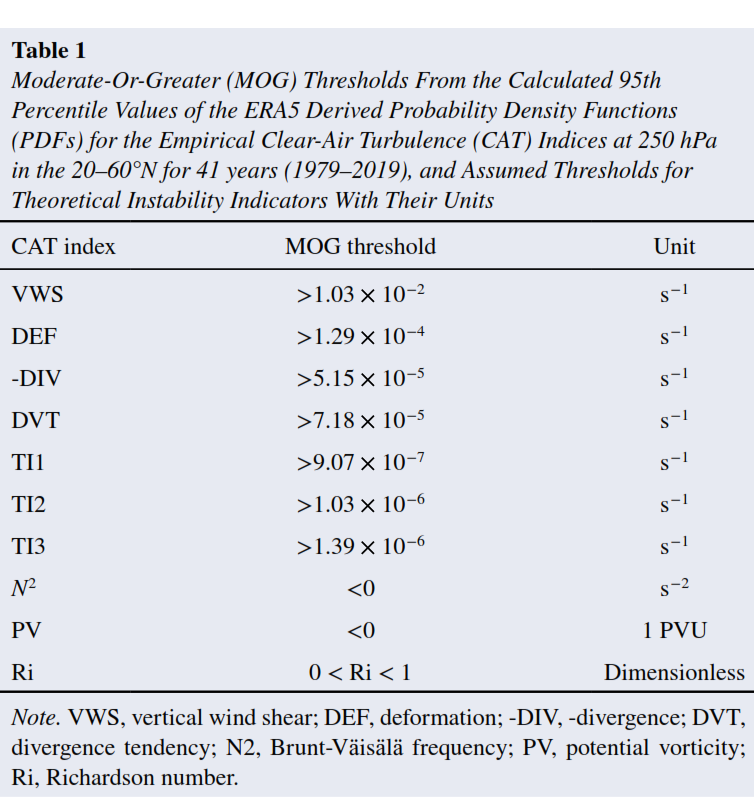

In [ ]:
# use a scratch temp file to calculate and store indices.
# tmpfilename= f'/scratch/eg3/{user}/tmp/{activity}_{model}_{var}_{scenario}_tmp.nc'

In [ ]:
%%time
windspeed_barpa = ds_barpa['windspeed'].sel(pressure=250).mean("time").compute()
windspeed_barpa.plot()

In [ ]:
%%time
windspeed_era = ds_era5['windspeed'].sel(pressure=250, time=slice("1980", "1981")).mean("time").compute()
windspeed_era.plot()

In [ ]:
mog = ds_era5["windspeed"].sel(pressure=250, 
                               lat=slice(-60, -20),
                               # time=slice("1979","2019")
                              ).quantile([0.99]).compute()
mog

In [ ]:
%%time
(windspeed_barpa - windspeed_era).plot()


In [ ]:
nrows = 1
ncols = 3
figsize = (8,6)
projection = ccrs.LambertConformal(
                central_latitude=-24.75,
                central_longitude=134.0,
                cutoff=30,
                standard_parallels=(-10, -40),
            )

fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            sharey=True, sharex=True, 
                            figsize=figsize,
                            layout="constrained",
                            subplot_kw={"projection":projection , "frame_on":False},)


axs[0].pcolormesh(windspeed_era.lon, windspeed_era.lat, windspeed_era, cmap=cm.viridis, transform=ccrs.PlateCarree(),)
axs[1].pcolormesh(windspeed_era.lon, windspeed_era.lat, windspeed_barpa, cmap=cm.viridis, transform=ccrs.PlateCarree(),)
axs[2].pcolormesh(windspeed_era.lon, windspeed_era.lat, (windspeed_barpa - windspeed_era), cmap=cm.RdBu, transform=ccrs.PlateCarree(),)

for i in range(3):
    axs[i].coastlines(resolution = "10m", zorder=5, linewidth=0.5,)
    axs[i].set_title(["era5", "barpa", "barpa - era5"][i])


In [ ]:
%%time
ds1 = windspeed_barpa
cmap1 = cmap_dict['ipcc_wind_seq']
ticks1 = np.arange(0, 50, 5)
tick_interval1 = 1
tick_rotation1=0
cbar_label1 = "windspeed [m/s]"
cbar_extend1="max"
agcd_mask1=False
subplot_titles1="barpa"
vcentre1=None

ds2 = windspeed_era
cmap2 =cmap_dict["ipcc_wind_seq"]
ticks2 = np.arange(0, 50, 5)
tick_interval2 = 1
tick_rotation2=0
cbar_label2 = "windspeed [m/s]"
cbar_extend2="max"
agcd_mask2=False
subplot_titles2="era"
vcentre2=None

plot_acs_hazard_multi(ds_list=[ds1, ds2],
                      ncols=2,
                      nrows=1,
                      figsize=(6.7,4.5),
                      regions=regions_dict['aus_states_territories'],
                      title= "Windspeed at 250hPa",
                      date_range="compare BARPA and ERA5",
                      cmap= [ cmap1, cmap2],
                      ticks=[ticks1, ticks2],
                      tick_interval=[tick_interval1 , tick_interval2],
                      tick_rotation=[tick_rotation1, tick_rotation2],
                      cbar_label=[cbar_label1, cbar_label2],
                      cbar_extend = [cbar_extend1, cbar_extend2],
                      agcd_mask=[agcd_mask1, agcd_mask2],
                      subplot_titles=[subplot_titles1, subplot_titles2],
                      vcentre=[vcentre1, vcentre2],
                     share_cbar=False,
                      mask_not_australia=False,
                     watermark="",
                     show_copyright=False,)                      

In [ ]:
%%time
ds1 = windspeed_barpa
cmap1 = cmap_dict['ipcc_wind_seq']
ticks1 = np.arange(0, 50, 5)
tick_interval1 = 1
tick_rotation1=0
cbar_label1 = "windspeed [m/s]"
cbar_extend1="max"
agcd_mask1=False
subplot_titles1="barpa"
vcentre1=None

ds2 = windspeed_era
cmap2 =cmap_dict["ipcc_wind_seq"]
ticks2 = np.arange(0, 50, 5)
tick_interval2 = 1
tick_rotation2=0
cbar_label2 = "windspeed [m/s]"
cbar_extend2="max"
agcd_mask2=False
subplot_titles2="era"
vcentre2=None

ds3 = windspeed_barpa - windspeed_era
cmap3 =cmap_dict["ipcc_wind_div"]
ticks3 = np.arange(-10, 11, 2)
tick_interval3 = 1
tick_rotation3=0
cbar_label3 = "windspeed [m/s]"
cbar_extend3="both"
agcd_mask3=False
subplot_titles3="barpa - era"
vcentre3=0

plot_acs_hazard_multi(ds_list=[ds1, ds2, ds3],
                      ncols=3,
                      nrows=1,
                      figsize=(6.7,4),
                      regions=regions_dict['aus_states_territories'],
                      title= "Windspeed at 250hPa",
                      date_range="compare BARPA and ERA5",
                      cmap= [ cmap1, cmap2, cmap3],
                      ticks=[ticks1, ticks2, ticks3],
                      tick_interval=[tick_interval1 , tick_interval2, tick_interval3],
                      tick_rotation=[tick_rotation1, tick_rotation2, tick_rotation3],
                      cbar_label=[cbar_label1, cbar_label2, cbar_label3],
                      cbar_extend = [cbar_extend1, cbar_extend2, cbar_extend3],
                      agcd_mask=[agcd_mask1, agcd_mask2, agcd_mask3],
                      subplot_titles=[subplot_titles1, subplot_titles2, subplot_titles3],
                      vcentre=[vcentre1, vcentre2, vcentre3],
                     share_cbar=False,
                      mask_not_australia=False,
                     watermark="",
                     show_copyright=False,)                      

In [ ]:
fig, ax = plt.subplots(1, subplot_kw={"projection":ccrs.PlateCarree(180)})
ax.pcolormesh(windspeed_era.lon, windspeed_era.lat, windspeed_era, cmap=cm.viridis,  transform=ccrs.PlateCarree())
ax.coastlines(resolution = "10m", zorder=5, linewidth=0.5,)

In [ ]:
%%time
barpa_vws = ds_barpa['VWS'].mean("time").compute()
barpa_vws.plot()

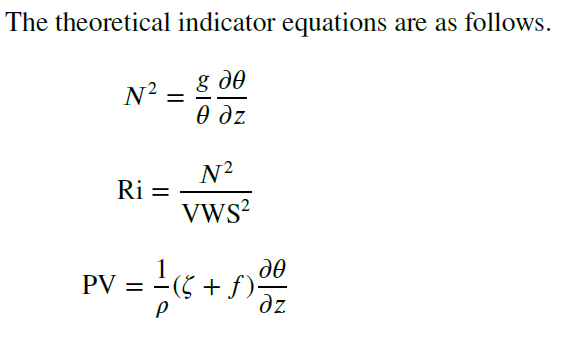

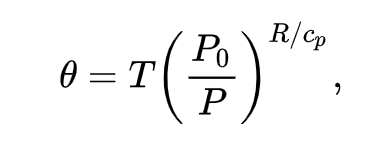


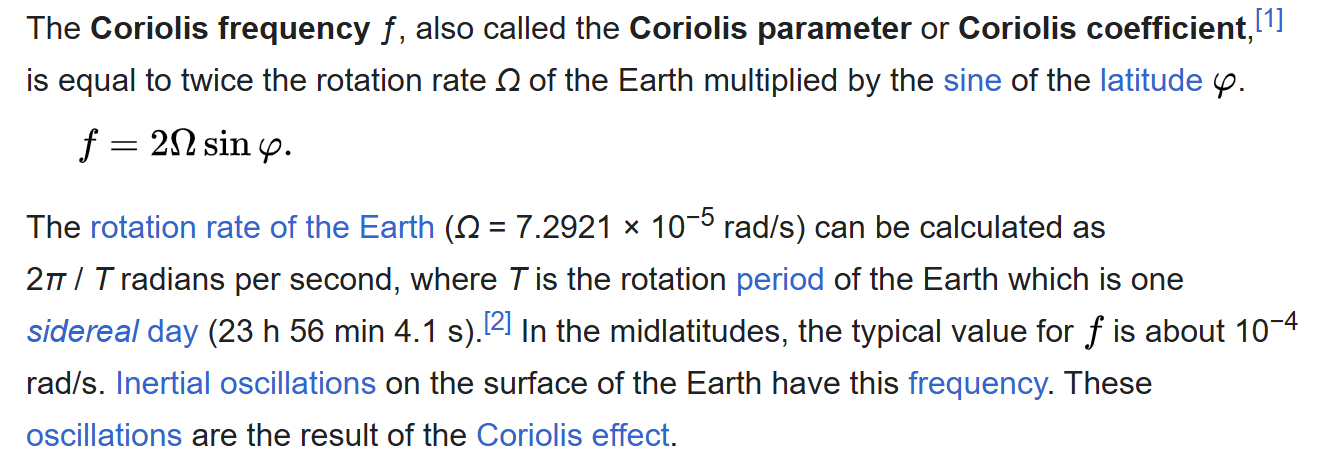

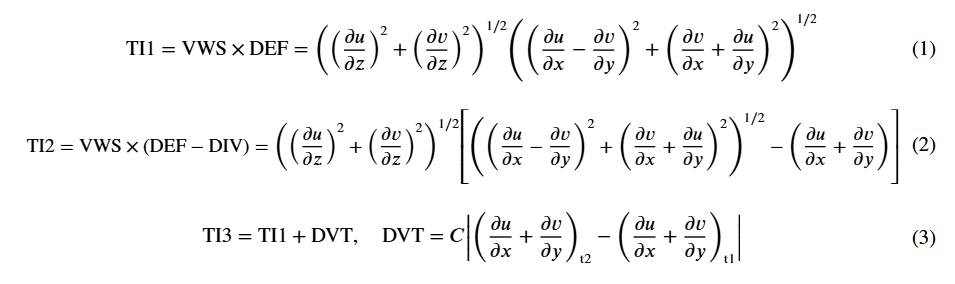


In [ ]:
ax = plt.subplot(projection=ccrs.Robinson(130))
DIV.isel(time=0).plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
ax = plt.subplot(projection=ccrs.Robinson(130))
DEF.isel(time=0).plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:

ax = plt.subplot(projection=ccrs.Robinson(130))
DVT.plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
# This probably is a jet stream signature.

ax = plt.subplot(projection=ccrs.Robinson(130))
TI1.mean("time").plot(transform=ccrs.PlateCarree())
ax.coastlines()



In [ ]:

ax = plt.subplot(projection=ccrs.Robinson(130))
VWS.mean("time").plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
# This probably is a jet stream signature.

fig, ax = plot_acs_hazard_multi(nrows=1,
                                ncols=1,
                                ds_list=[TI1.mean("time")], 
                            xlim=(100, 190),
                            ylim=(-55, 10),
                            cmap=cm.viridis,
                            ticks=np.arange(0,0.000005, 0.0000002),
                            mask_not_australia=False,
                            mask_australia=False,
                            watermark="",
                            projection=ccrs.Robinson(central_longitude=130),
                            coastlines=True,
                          show_copyright=False,
                          issued_date="",
                          title="TI1",
                            )



In [ ]:
ax = plt.subplot(projection=ccrs.Robinson(130))
pv.isel(time=0).sel(pressure=250).plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
ax = plt.subplot(projection=ccrs.Robinson(130))
pv.sel(pressure=250).mean("time").plot(transform=ccrs.PlateCarree())
ax.coastlines()